In [3]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import torch
from torch.utils.data import random_split,DataLoader,TensorDataset
from PIL import Image
import torchvision
import os

### Actividad de CNN

In [23]:
from torchvision import transforms,datasets

transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
path = "pieces"
dataset = datasets.ImageFolder(path,transform=transform)
train_set,val_set,test_set = random_split(dataset,[400,125,126],generator=torch.Generator().manual_seed(619))
train_loader = DataLoader(train_set,batch_size=16,shuffle=True)
val_loader = DataLoader(val_set,batch_size=16,shuffle=True)
test_loader = DataLoader(test_set,batch_size=16,shuffle=True)   

En el siguiente bloque explore la data, con el fin de responder a estas preguntas.  
- ¿De que se trata el dataset?
- ¿Cuales son las clases de salida?
- ¿Cuantas imagenes hay por clase?
- ¿Cual es el tamaño de las imagenes?
- ¿Cuantas imagenes hay en total?
- Grafique algunas imagenes de cada clase
- etc.

El dataset contiene imágenes de piezas de ajedrez.
Clases de salida: ['bishop', 'knight', 'pawn', 'queen', 'rook']
Número de imágenes por clase:
bishop: 141
knight: 174
pawn: 82
queen: 115
rook: 139
Tamaño de las imágenes: torch.Size([3, 224, 224])
Número total de imágenes: 651


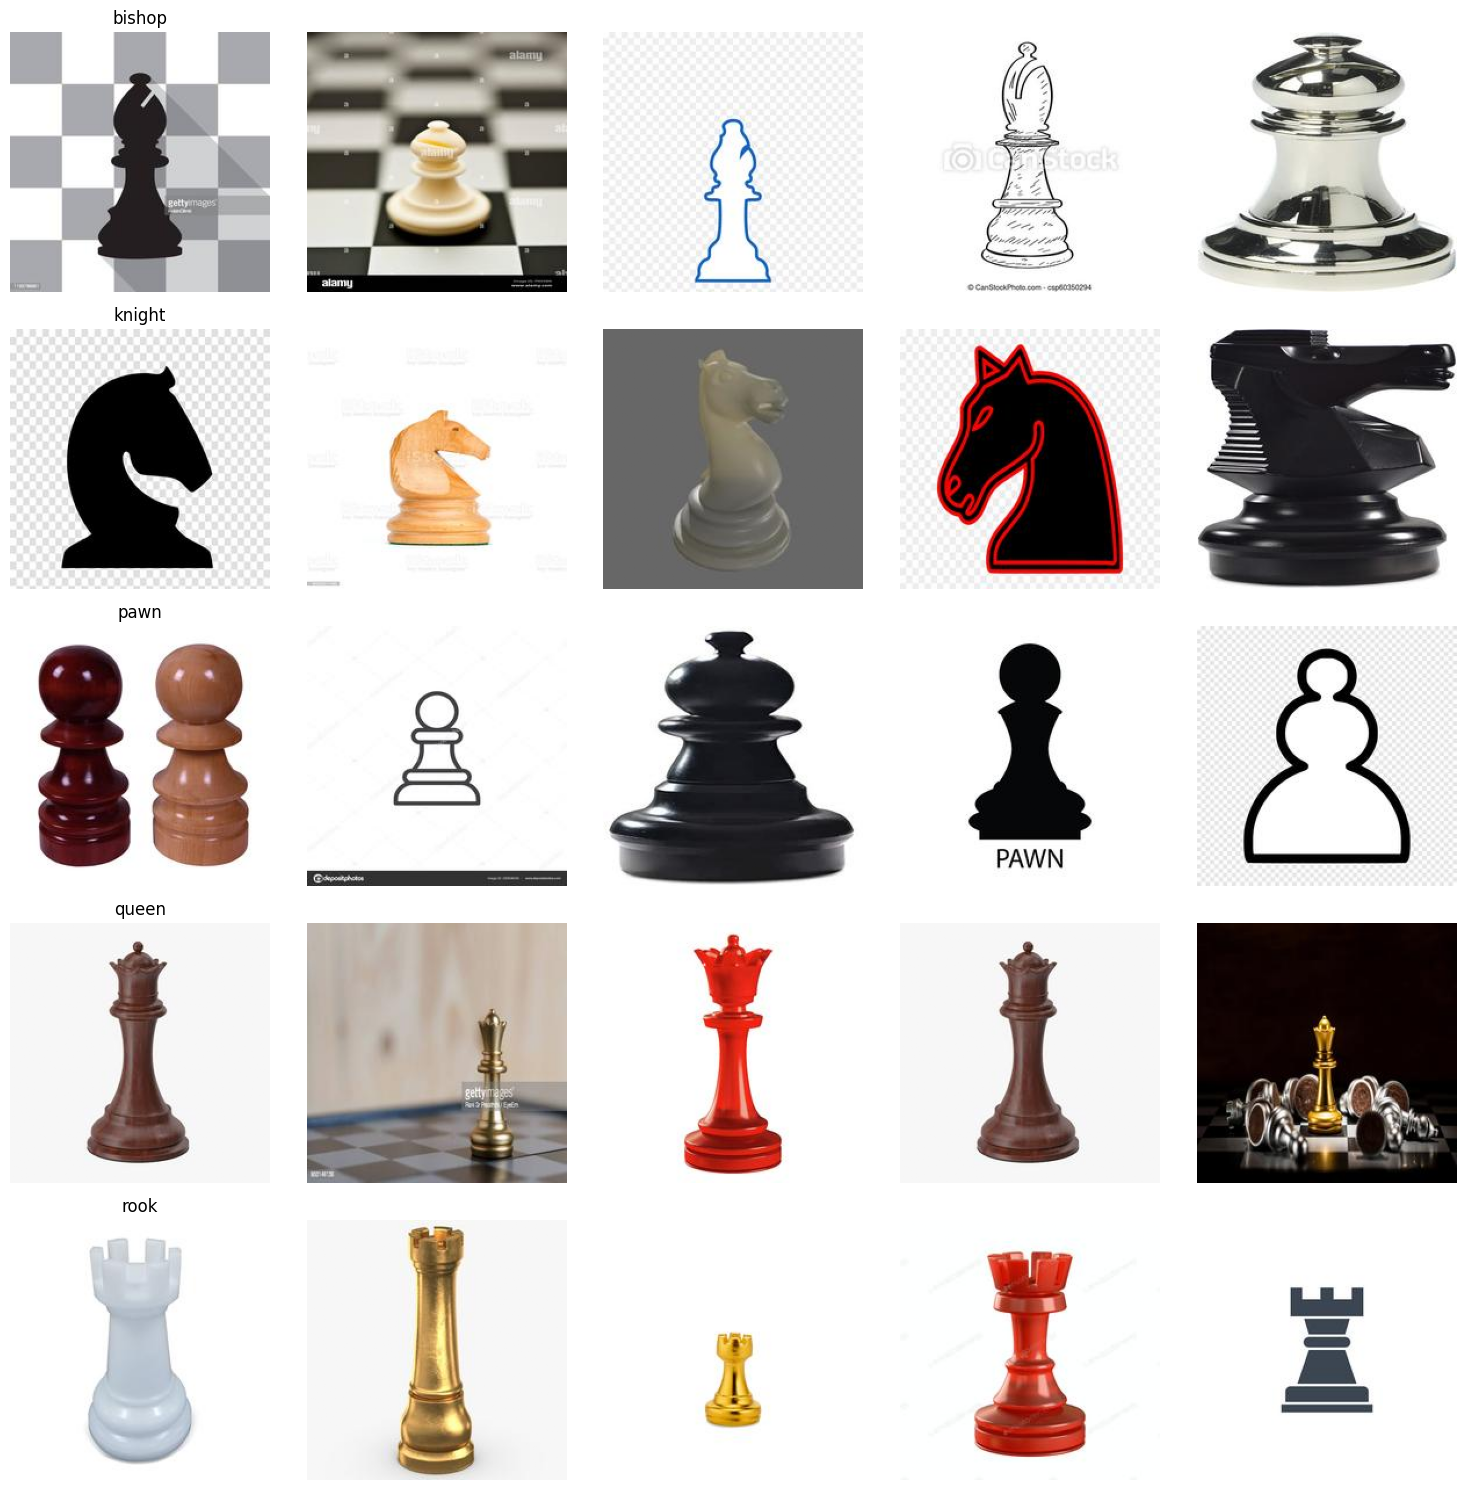


Tamaño del conjunto de entrenamiento: 400
Tamaño del conjunto de validación: 125
Tamaño del conjunto de prueba: 126
Tamaño del lote de entrenamiento: torch.Size([16, 3, 224, 224])

Mapeo de etiquetas numéricas a clases:
0: bishop
1: knight
2: pawn
3: queen
4: rook


In [24]:
# ¿De qué se trata el dataset?
print("El dataset contiene imágenes de piezas de ajedrez.")

# ¿Cuáles son las clases de salida?
classes = dataset.classes
print(f"Clases de salida: {classes}")

# ¿Cuántas imágenes hay por clase?
class_counts = {class_name: len([img for img, label in dataset.samples if dataset.classes[label] == class_name])
                for class_name in classes}
print("Número de imágenes por clase:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# ¿Cuál es el tamaño de las imágenes?
sample_img, _ = dataset[0]
print(f"Tamaño de las imágenes: {sample_img.shape}")

# ¿Cuántas imágenes hay en total?
total_images = len(dataset)
print(f"Número total de imágenes: {total_images}")

# Visualización de imágenes por clase
def show_images(dataset, classes, num_images=5):
    fig, axes = plt.subplots(len(classes), num_images, figsize=(15, 3*len(classes)))
    for i, class_name in enumerate(classes):
        class_indices = [j for j, (_, label) in enumerate(dataset.samples) if dataset.classes[label] == class_name]
        for j in range(num_images):
            idx = np.random.choice(class_indices)
            img, _ = dataset[idx]
            ax = axes[i][j] if len(classes) > 1 else axes[j]
            ax.imshow(img.permute(1, 2, 0))
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name)
    plt.tight_layout()
    plt.show()

show_images(dataset, classes)

# Información adicional
print(f"\nTamaño del conjunto de entrenamiento: {len(train_set)}")
print(f"Tamaño del conjunto de validación: {len(val_set)}")
print(f"Tamaño del conjunto de prueba: {len(test_set)}")

# Verificar el tamaño de los lotes
for images, labels in train_loader:
    print(f"Tamaño del lote de entrenamiento: {images.shape}")
    break

# Mostrar las etiquetas numéricas y sus correspondientes clases
class_to_idx = dataset.class_to_idx
print("\nMapeo de etiquetas numéricas a clases:")
for class_name, idx in class_to_idx.items():
    print(f"{idx}: {class_name}")

En el siguiente bloque implemente el modelo que le permitirá clasificar las diferentes tipos de piezas en el ajedrez, justifique la arquitectura de la red.

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class ChessPieceClassifier(nn.Module):
    def __init__(self):
        super(ChessPieceClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 5)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Justificacion:
 1. Tenemos tres capas convolucionales (conv1, 2, 3) que van aumentando gradualmente el numero de filtros. Esto permite a la red aprender de manera gradual las caracteristicas de las piezas. Ademas, usamos padding = 1 que nos permite mantener las dimensiones espaciales despues de cada convolucion.
 2. Despues de cada convolucion aplicamos MaxPolling para reducir la dimensionalidad, lo que hace mas consistente a la red frente a pequeños cambios en las imagenes.
 3. Luegos de lo anterior, aplanamos la salida y lo pasamos por capas completamente conectadas. Con una capa de entrada de 512 y otra de salida de 5 caracteristicas. Una para cada clase de pieza de ajedrez.
 4. Usamos una capa Dropout para evitar el sobreajuste. Por dataset pequeño.
 5. Usamos ReLU como funcion de activacion, en las capas intermedias. Por su eficiencia.
 6. Finalmente, la red esta construida para manejar imagenes de 224x224 pixeles con 3 canales de color.

En resumen, es una arquitectura compleja para capturar las caractiristicas que diferencian a las piezas pero no tan profunda como para causar sobreajuste. La combinacion de capas convolucionales, pooling y capas lineales nos permite aprender las formas de las piezas asi como las que diferencian las clases.

Se puede mejorar con: Regularización L2 en las capas fully connected para reducir aún más el riesgo de sobreajuste. ??
_____________________

En el siguiente bloque cree una instancia de su red neuronal convolucional definida anteriormente y defina una función de perdida y un optimizador.	

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.cuda.empty_cache()


Using device: cuda


In [29]:
import torch.optim as optim

model = ChessPieceClassifier().to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 

In [ ]:
criterion = nn.CrossEntropyLoss()
# Utilizamos CrossEntropyLoss(), que es apropiada para problemas de clasificación multiclase.
# Esta función combina LogSoftmax y NLLLoss en una sola clase.  
# Es ideal para nuestro caso, ya que tenemos 5 clases mutuamente excluyentes.

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Adam es una buena elección general porque adapta la tasa de aprendizaje para cada parámetro,
# lo que lo hace eficiente y efectivo para una amplia gama de problemas.

En el siguiente bloque programe el entrenamiento de su red neuronal convolucional.

In [22]:
# Parámetros de entrenamiento
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Función para calcular la precisión
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

# Bucle de entrenamiento
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validación
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            val_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    
        # Limpieza de memoria CUDA (segunda solución)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


# Gráfico de pérdida y precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Guardar el modelo entrenado
torch.save(model.state_dict(), 'chess_piece_classifier.pth')

OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 

En el siguiente bloque muestre el gráfico de entrenamiento y validación de su red neuronal convolucional.

Muestre diferentes métricas de evaluación de su red neuronal convolucional.

Concluya sobre las métricas obtenidas y el entrenamiento de su red neuronal convolucional.

En el siguiente bloque muestre las predicciones de su red neuronal convolucional y responda:
- ¿Cree que los errores son razonables?
- ¿Qué haría para mejorar la clasificación de las piezas de ajedrez?
